# Calculating SimSAX

SimSAX (Similarity-based on Symbolic Aggregate approXimation) is a similarity measure between defect-inflow profiles.

In this notebook, we show how to calculate similarity between measures and identify so-called motifs (re-occuring) similar shapes in the defect inflows.

In [1]:
%reload_ext autoreload
%autoreload

# external imports
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# simsax
from simsax.projects import load_backlog
from simsax.alignment.model import ProjectSequence
from simsax.alignment.finders import calculate_project_alignment, create_sax_signature, find_motifs
from simsax.alignment.calculators import AlignmentsCoverageCalculator
from simsax.alignment.plot import plot_all_motif_alignments, plot_subplot_motif, plot_comparisons_motif

from sax.pysax import SAXModel

## 0. Acquire defect-inflow profiles

Obviously, before you can use SimSAX you need to collect data about defects (or other time series related to a project if you want to use it on). 

You will find a few examples of defect backlog data in the 'data-examples' folder. Each backlog csv file has to contain columns from_date and to_date which define a week for which the measures are calculated and a column that stores the number of events that occurred within the week (e.g., in the examples 'inflow_all' is the number of defects reports submitted each week).

In [2]:
# Here is an example of a defect backlog
backlog = pd.read_csv('./data-examples/eclipse_birt_backlog.csv', 
                      parse_dates=['from_date', 'to_date'], 
                      index_col=0)
backlog.head(2)

,number,from_date,to_date,backlog_all,inflow_all,outflow_all,backlog_normal,inflow_normal,outflow_normal,backlog_major,inflow_major,outflow_major
2005-01-10/2005-01-16,0,2005-01-10,2005-01-16,1,0,0,0,0,0,0,0,0
2005-01-17/2005-01-23,1,2005-01-17,2005-01-23,2,1,0,0,0,0,0,0,0


## 1. Load the defect backlog

We start from creating a project: 

In [3]:
project_a = load_backlog(backlogs_folder='./data-examples/', file_name='eclipse_jdt_sample_backlog.csv', 
                            source='Eclipse', dev_type='Open Source')

project_b = load_backlog(backlogs_folder='./data-examples/', file_name='eclipse_platform_sample_backlog.csv', 
                            source='Eclipse', dev_type='Open Source')

Then, we create a project sequence, which maps between the project and particular time series we are interested in:

In [4]:
project_a_seq = ProjectSequence(project_a, get_sequence=lambda x: x.backlog.inflow_all)
project_b_seq = ProjectSequence(project_b, get_sequence=lambda x: x.backlog.inflow_all)

## 2. Create SAX transformer

The time series are transformed into sequences of symbols using Symbolic Aggregate approXimation (SAX). You need to provide at lest these three parameters:
* window = the length of subsequences to be compared
* nbins = the length of the sequences after dimension reduction
* alphabet = a list containint the symbols in the alphabet 

You can determine these values using a simulation (see the other Jupyter notebook for details).

We use here the SAX implementation from https://github.com/dolaameng/pysax.git with a few bug-fixes and modifications of our own.

In [5]:
window = 64
nbins = 5
alphabet = 6
alphabet = string.ascii_lowercase[:alphabet]

In [6]:
sax = SAXModel(
        window=window,
        nbins=nbins,
        alphabet=alphabet,
        epsilon=0.05)

## 3. Transform sequences with SAX

In [7]:
project_a_seq.transform_project_dna(sax)
project_b_seq.transform_project_dna(sax)

## 4. Find alignments and motifs in time series

In the next step, we need to find the matching windows. Here, we look for alignments *between* the time series and *within* each of them. Then, group those within a minimum distance to form a repeating motif.

In [8]:
# score thresholds defines what % of symbols between the compared windows has to match to call them similar
score_threshold = 1.0 

# it is a minimal distance between windows to treat them as different ones 
min_dist = 1

# we find similar windows between both time series
alignments_between = calculate_project_alignment(project_a_seq, project_b_seq, 
                                                 create_sax_signature(sax), 
                                                 min_dist ,score_threshold)

# we find internal similarities within each of the time series
project_a_within = calculate_project_alignment(project_a_seq, project_a_seq, 
                                               create_sax_signature(sax), 
                                               min_dist,score_threshold)
project_b_within = calculate_project_alignment(project_b_seq, project_b_seq, 
                                               create_sax_signature(sax), 
                                               min_dist,score_threshold)


In [9]:
# get motifs
motifs_between = find_motifs(alignments_between)
motifs_project_a_within = find_motifs(project_a_within)
motifs_project_b_within = find_motifs(project_b_within)

## 5. Calculate SimSAX

SimSAX$_{n,w,a}$(A,B) is a tuple (X, Y), where X is the percentage of weeks in the defect inflow A covered by at least one motif of length $n$ found in both defect inflows A and B (similarly, Y is the percentage of weeks in the defect inflow B covered by any of the motifs). 

In [10]:
calc = AlignmentsCoverageCalculator(alignments_between, 
                                    {project_a_seq.project:project_a_within, 
                                     project_b_seq.project:project_b_within})

calc.calculate_weeks()
calc.metrics

{<eclipse_jdt_sample_backlog.csv, Eclipse, Open Source>: {'between_coverage': 0.9807692307692307,
  'unique_between_coverage': 0.009615384615384616,
  'unique_within_coverage': 0.0,
  'within_coverage': 0.9711538461538461},
 <eclipse_platform_sample_backlog.csv, Eclipse, Open Source>: {'between_coverage': 0.9519230769230769,
  'unique_between_coverage': 0.0,
  'unique_within_coverage': 0.04807692307692308,
  'within_coverage': 1.0}}

In [11]:
print("SimSAX_{},{},{}(A, B) = ({:.2f}, {:.2f})".format(window, nbins, len(alphabet), 
                                               calc.metrics[project_a]['between_coverage'],
                                               calc.metrics[project_b]['between_coverage']
                                              ))

SimSAX_64,5,6(A, B) = (0.98, 0.95)


## Plot motifs

In addition to calculating SimSAX, you may want to visualize the motifs found in the time series.

Let's plot all motifs one by one in the context of orginal time series:

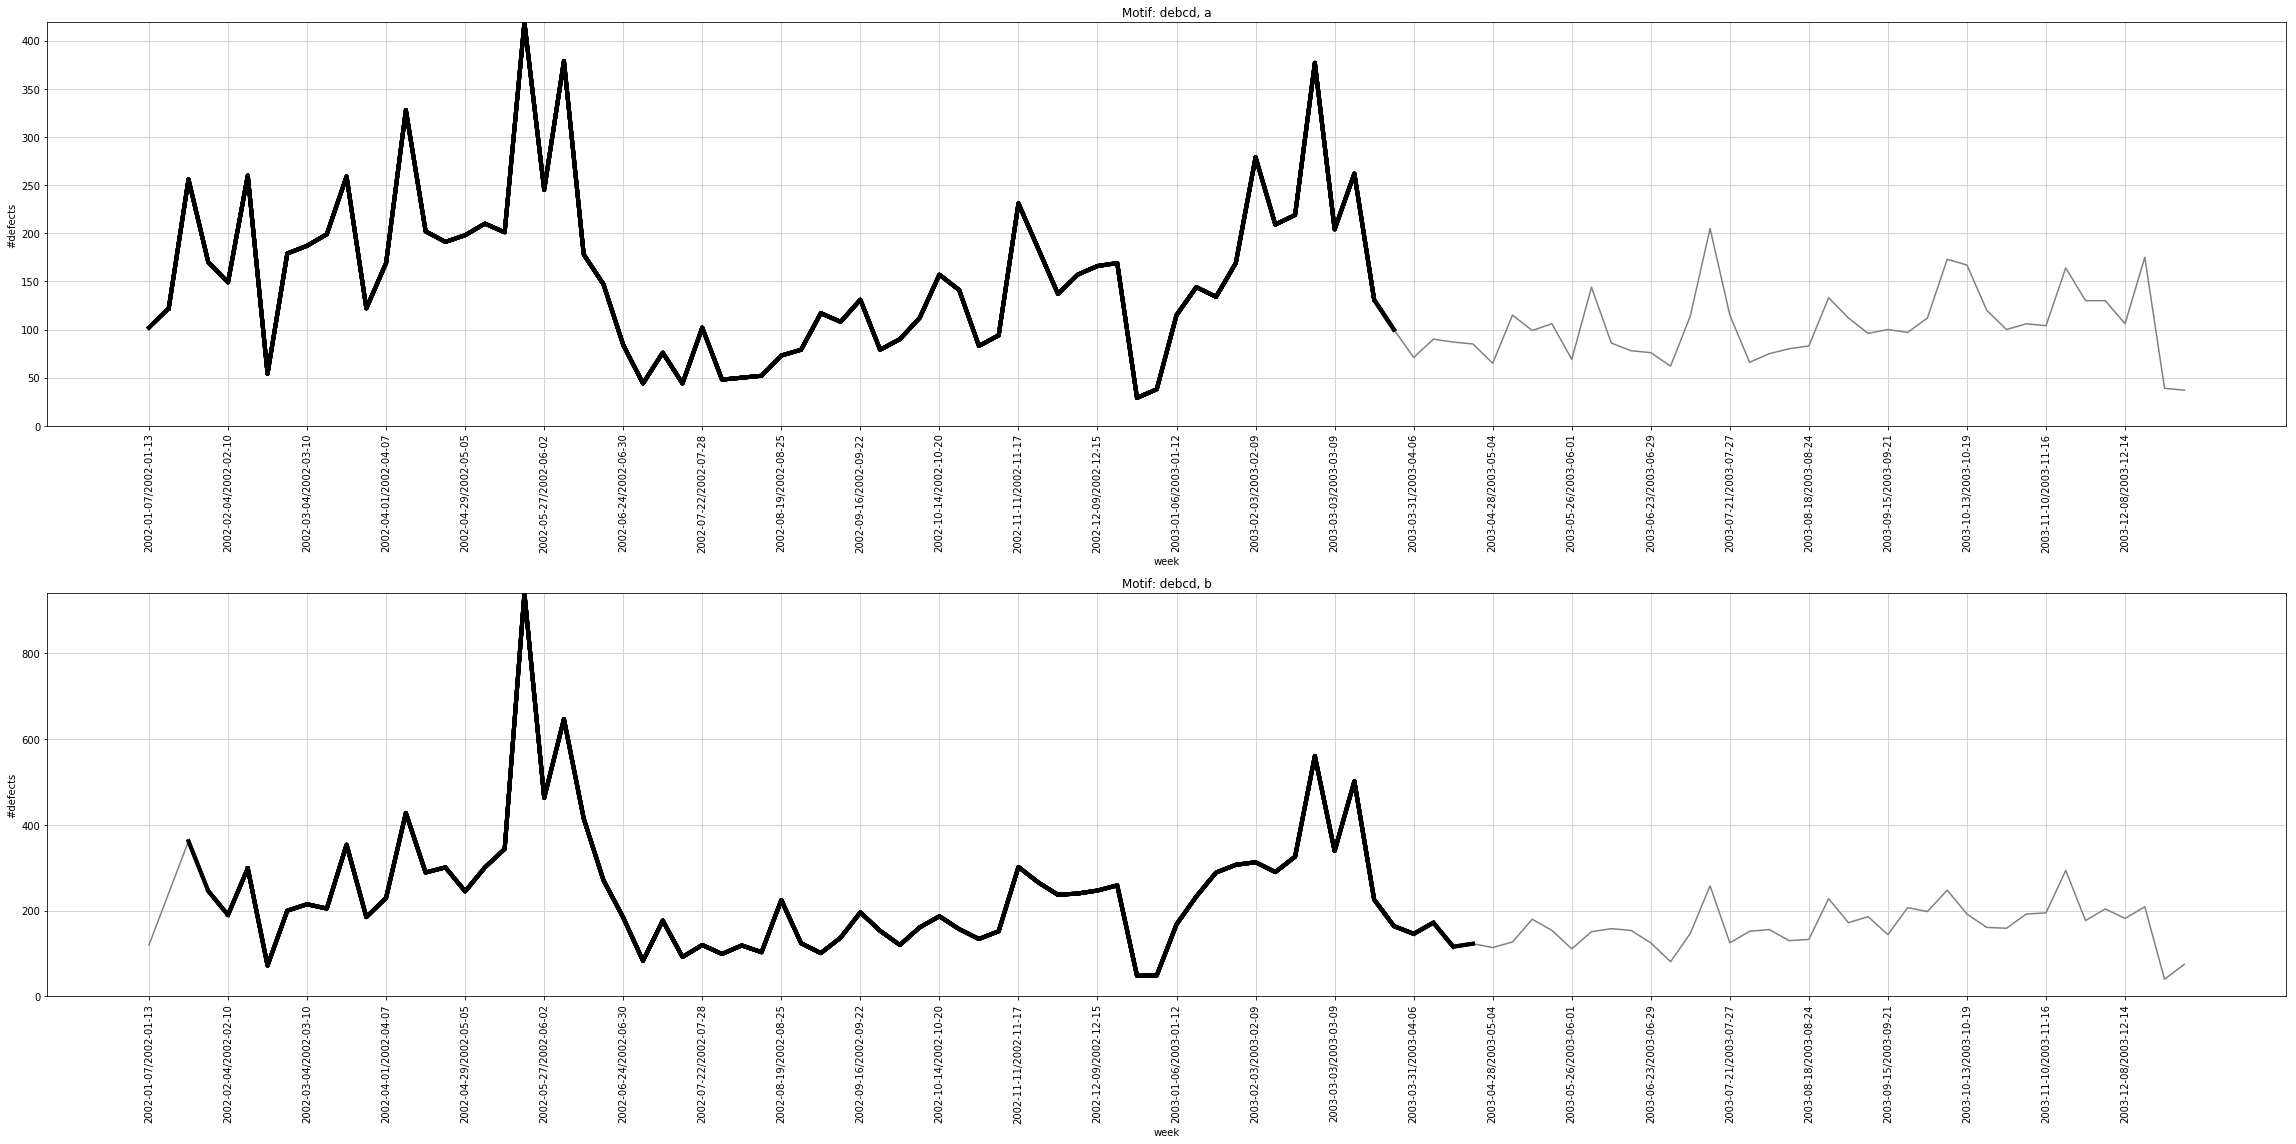

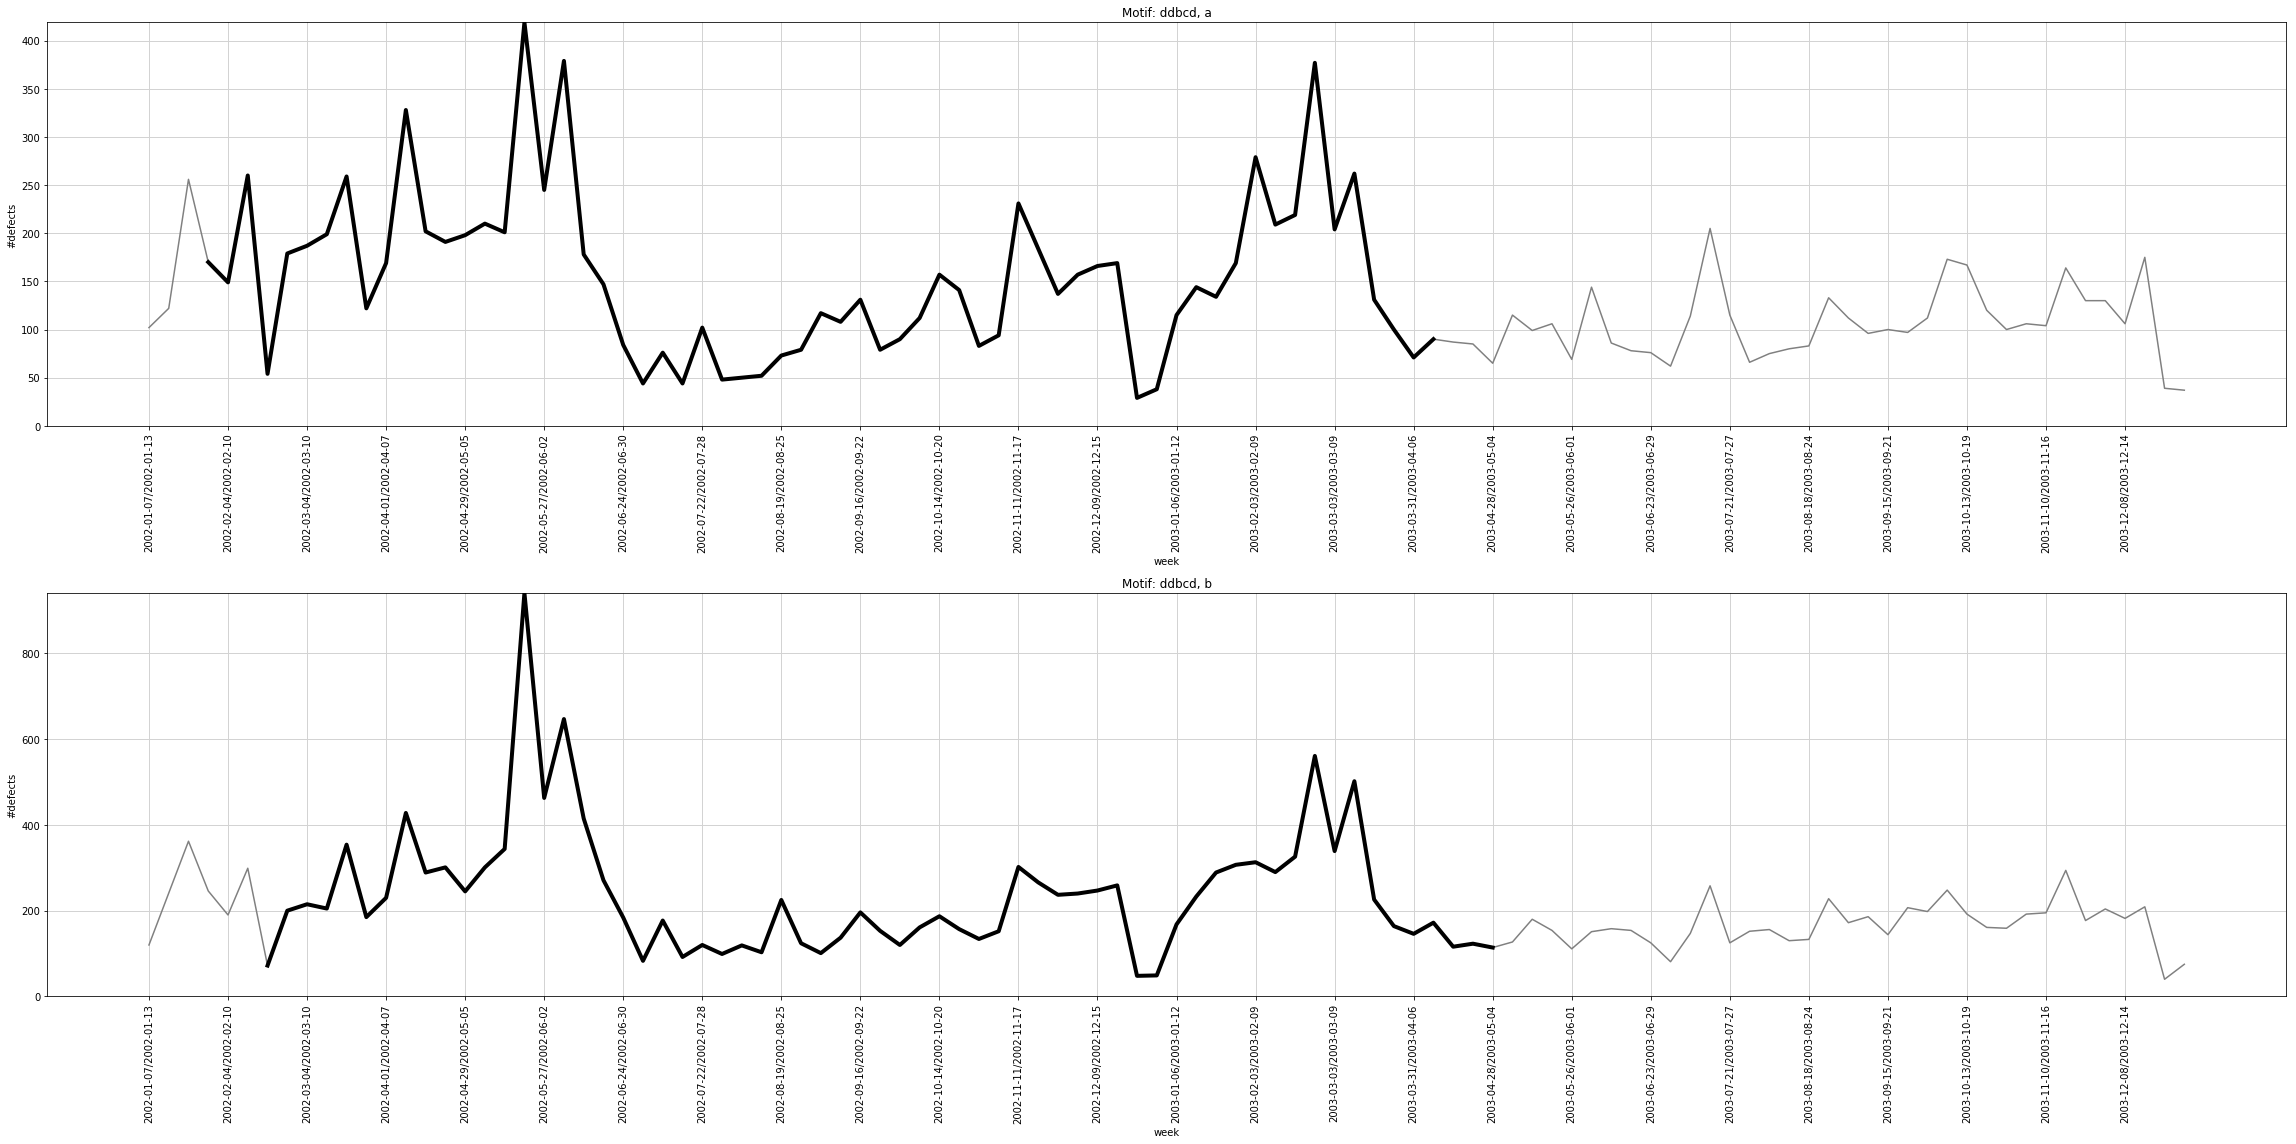

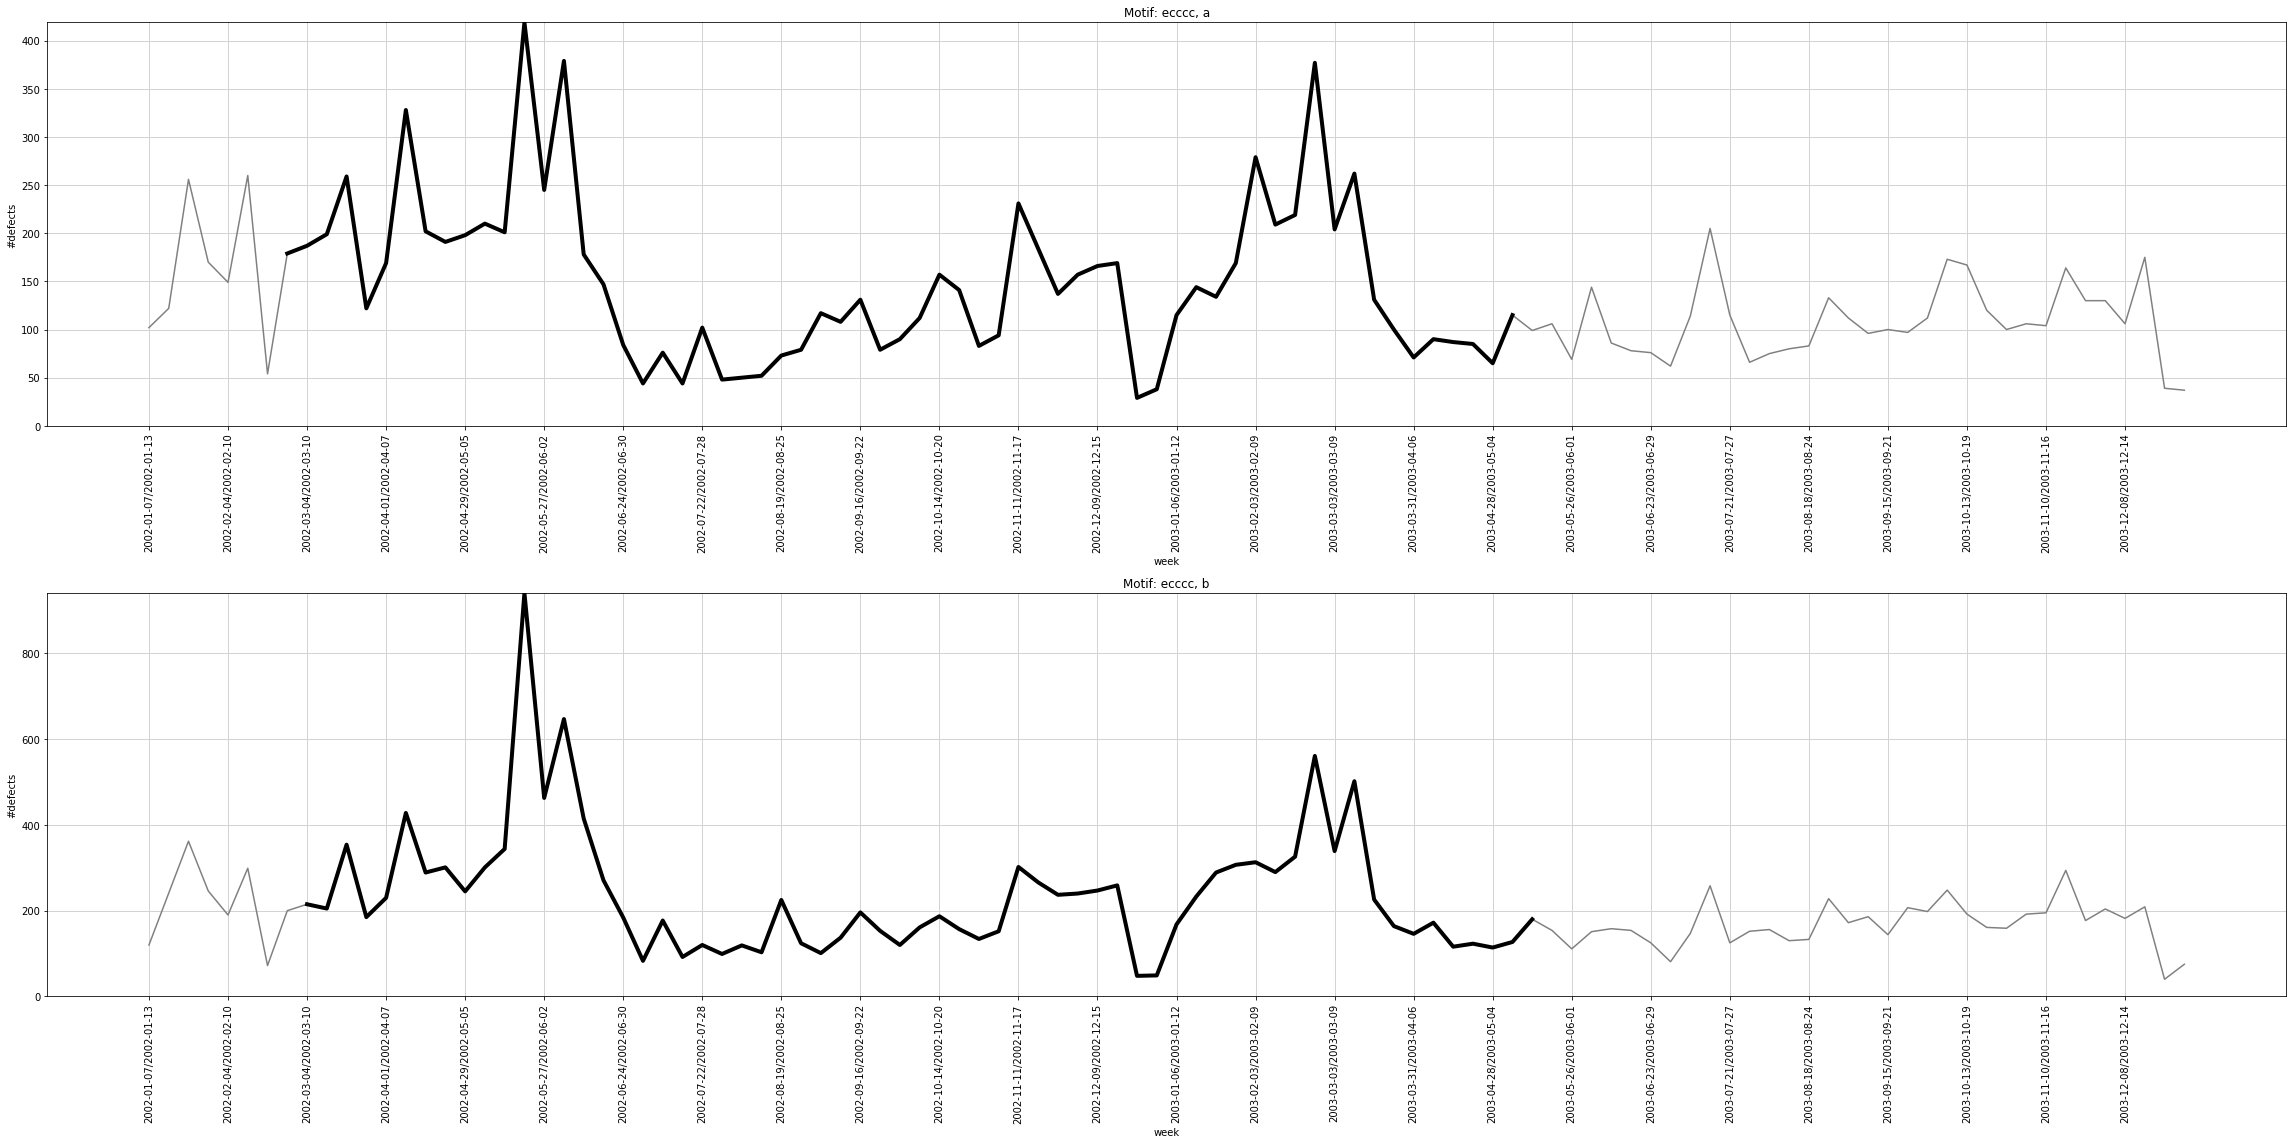

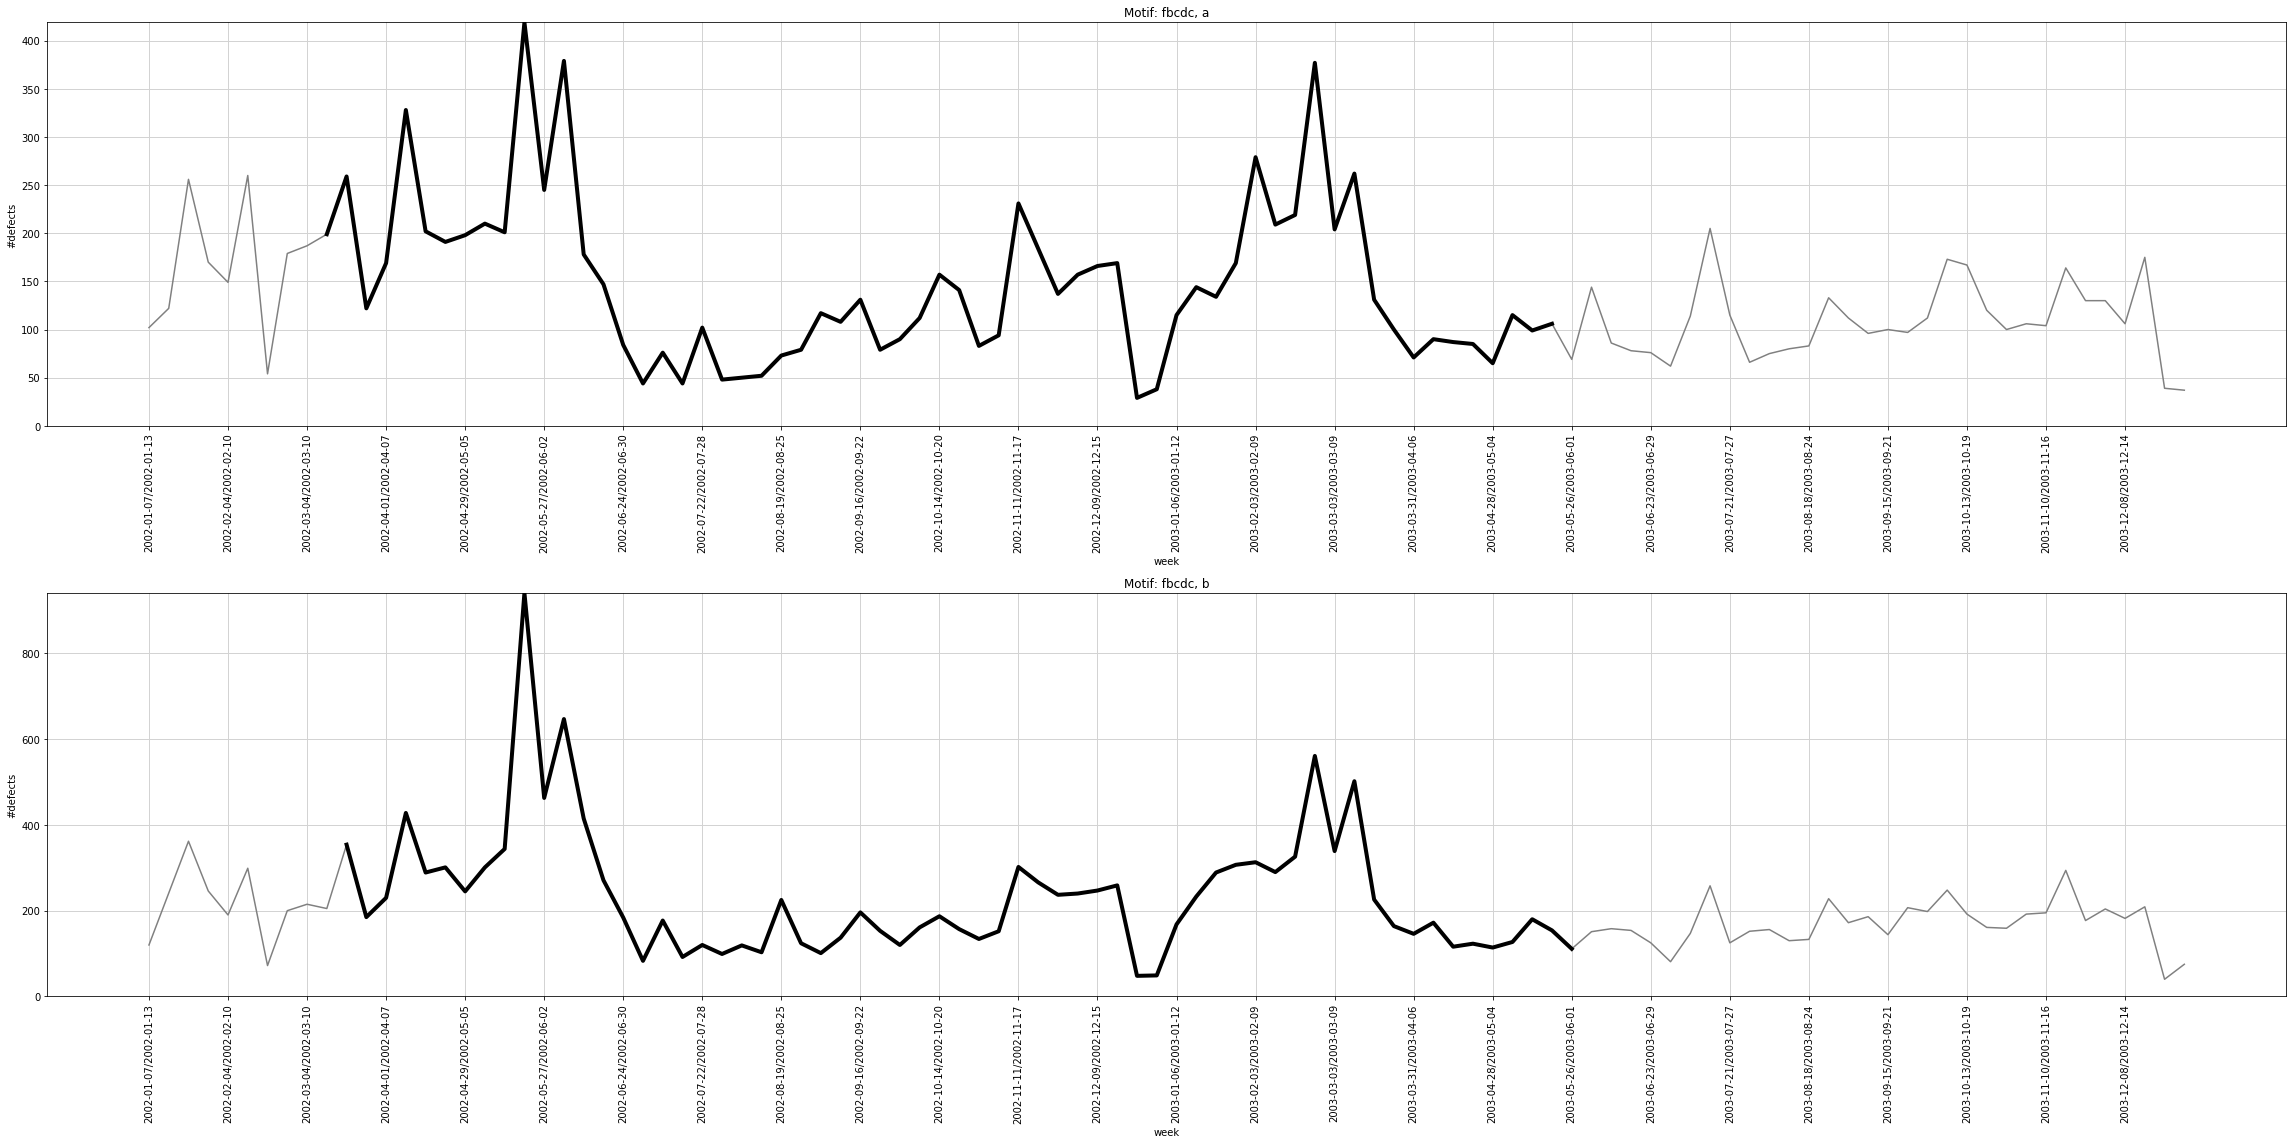

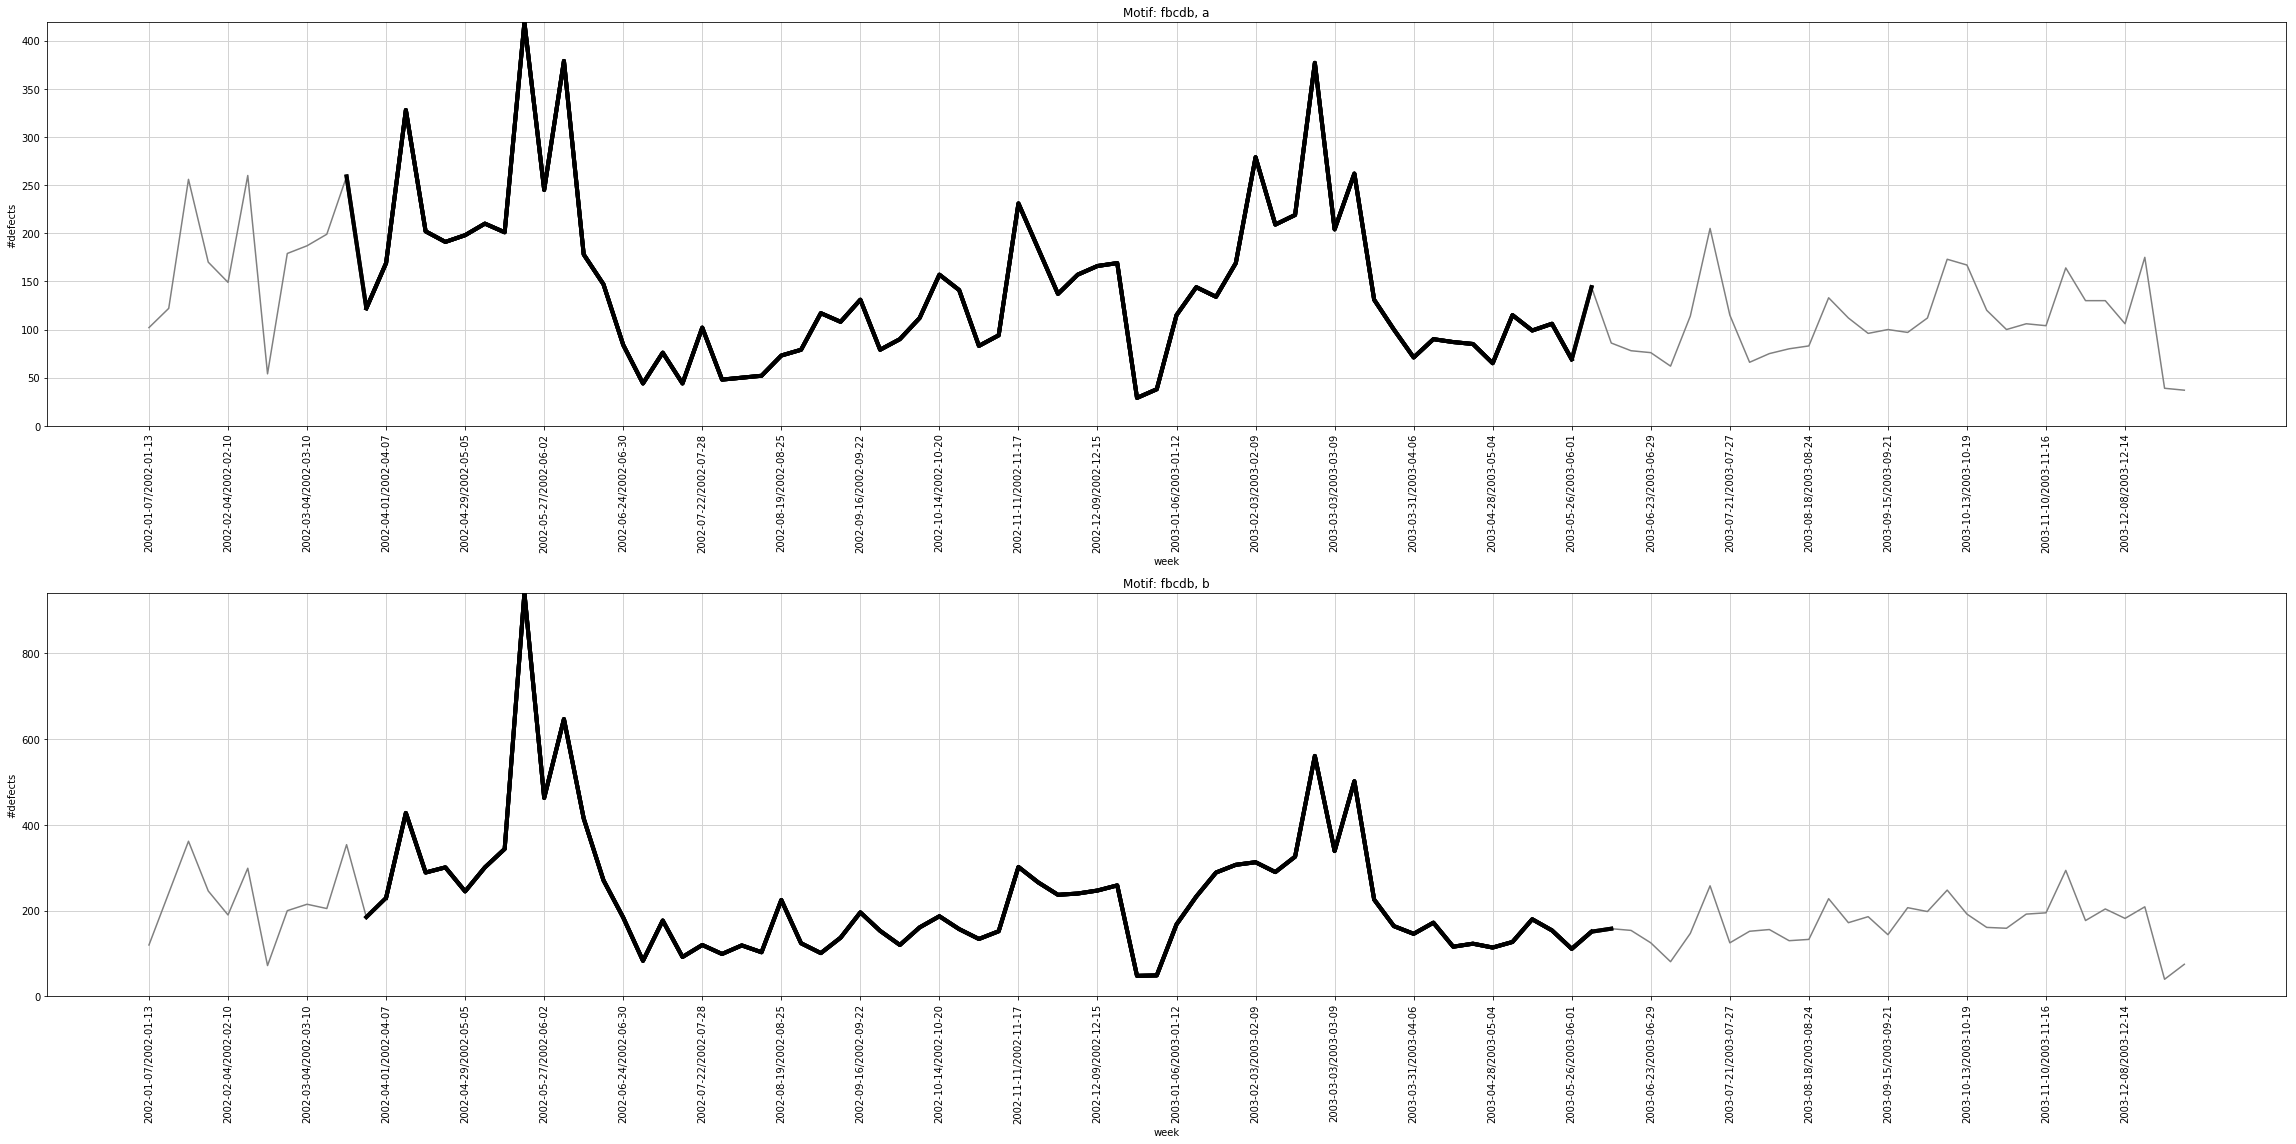

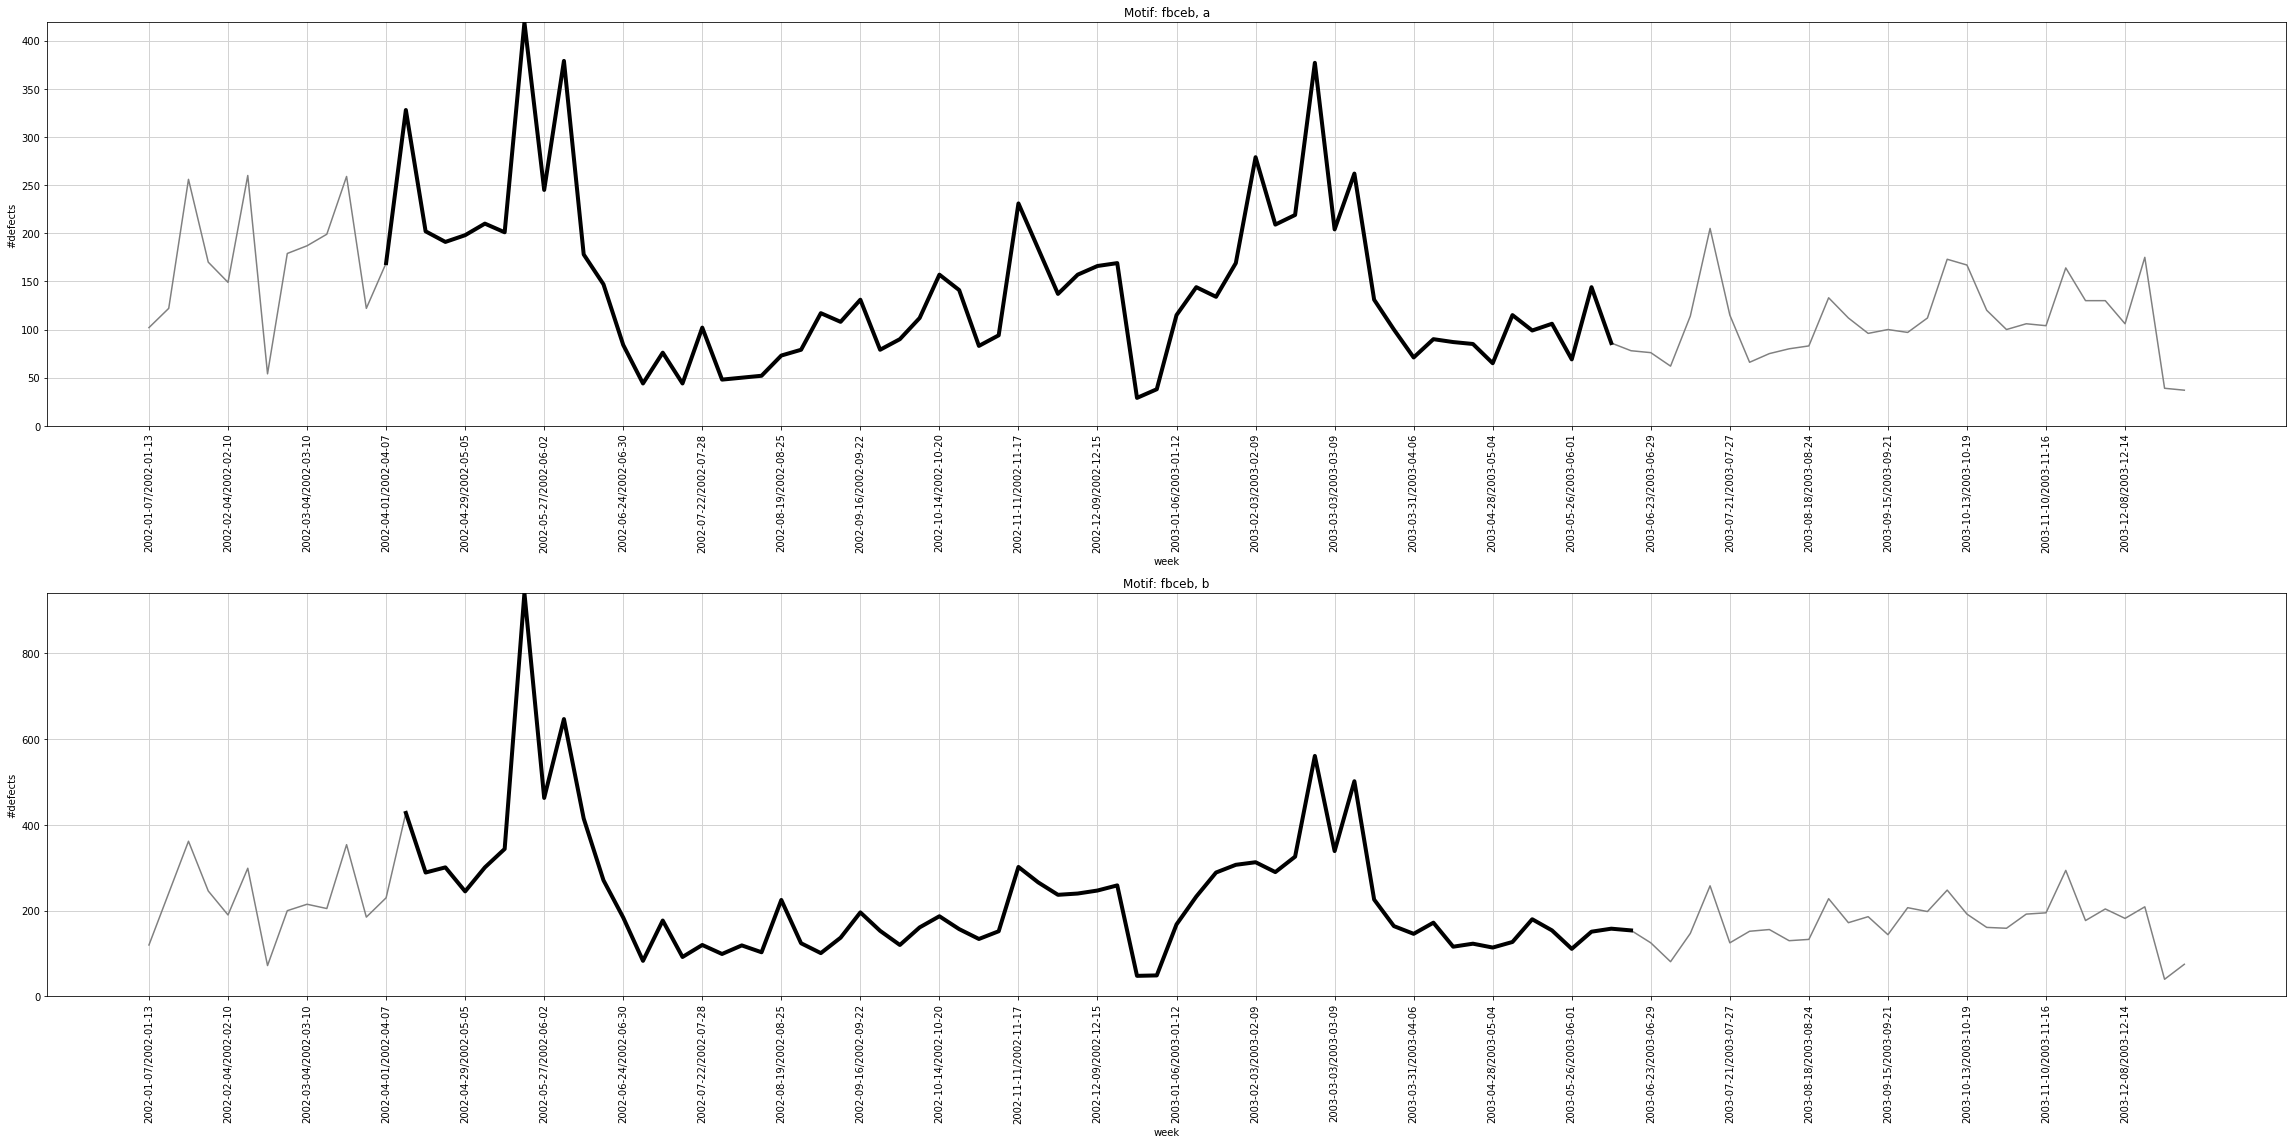

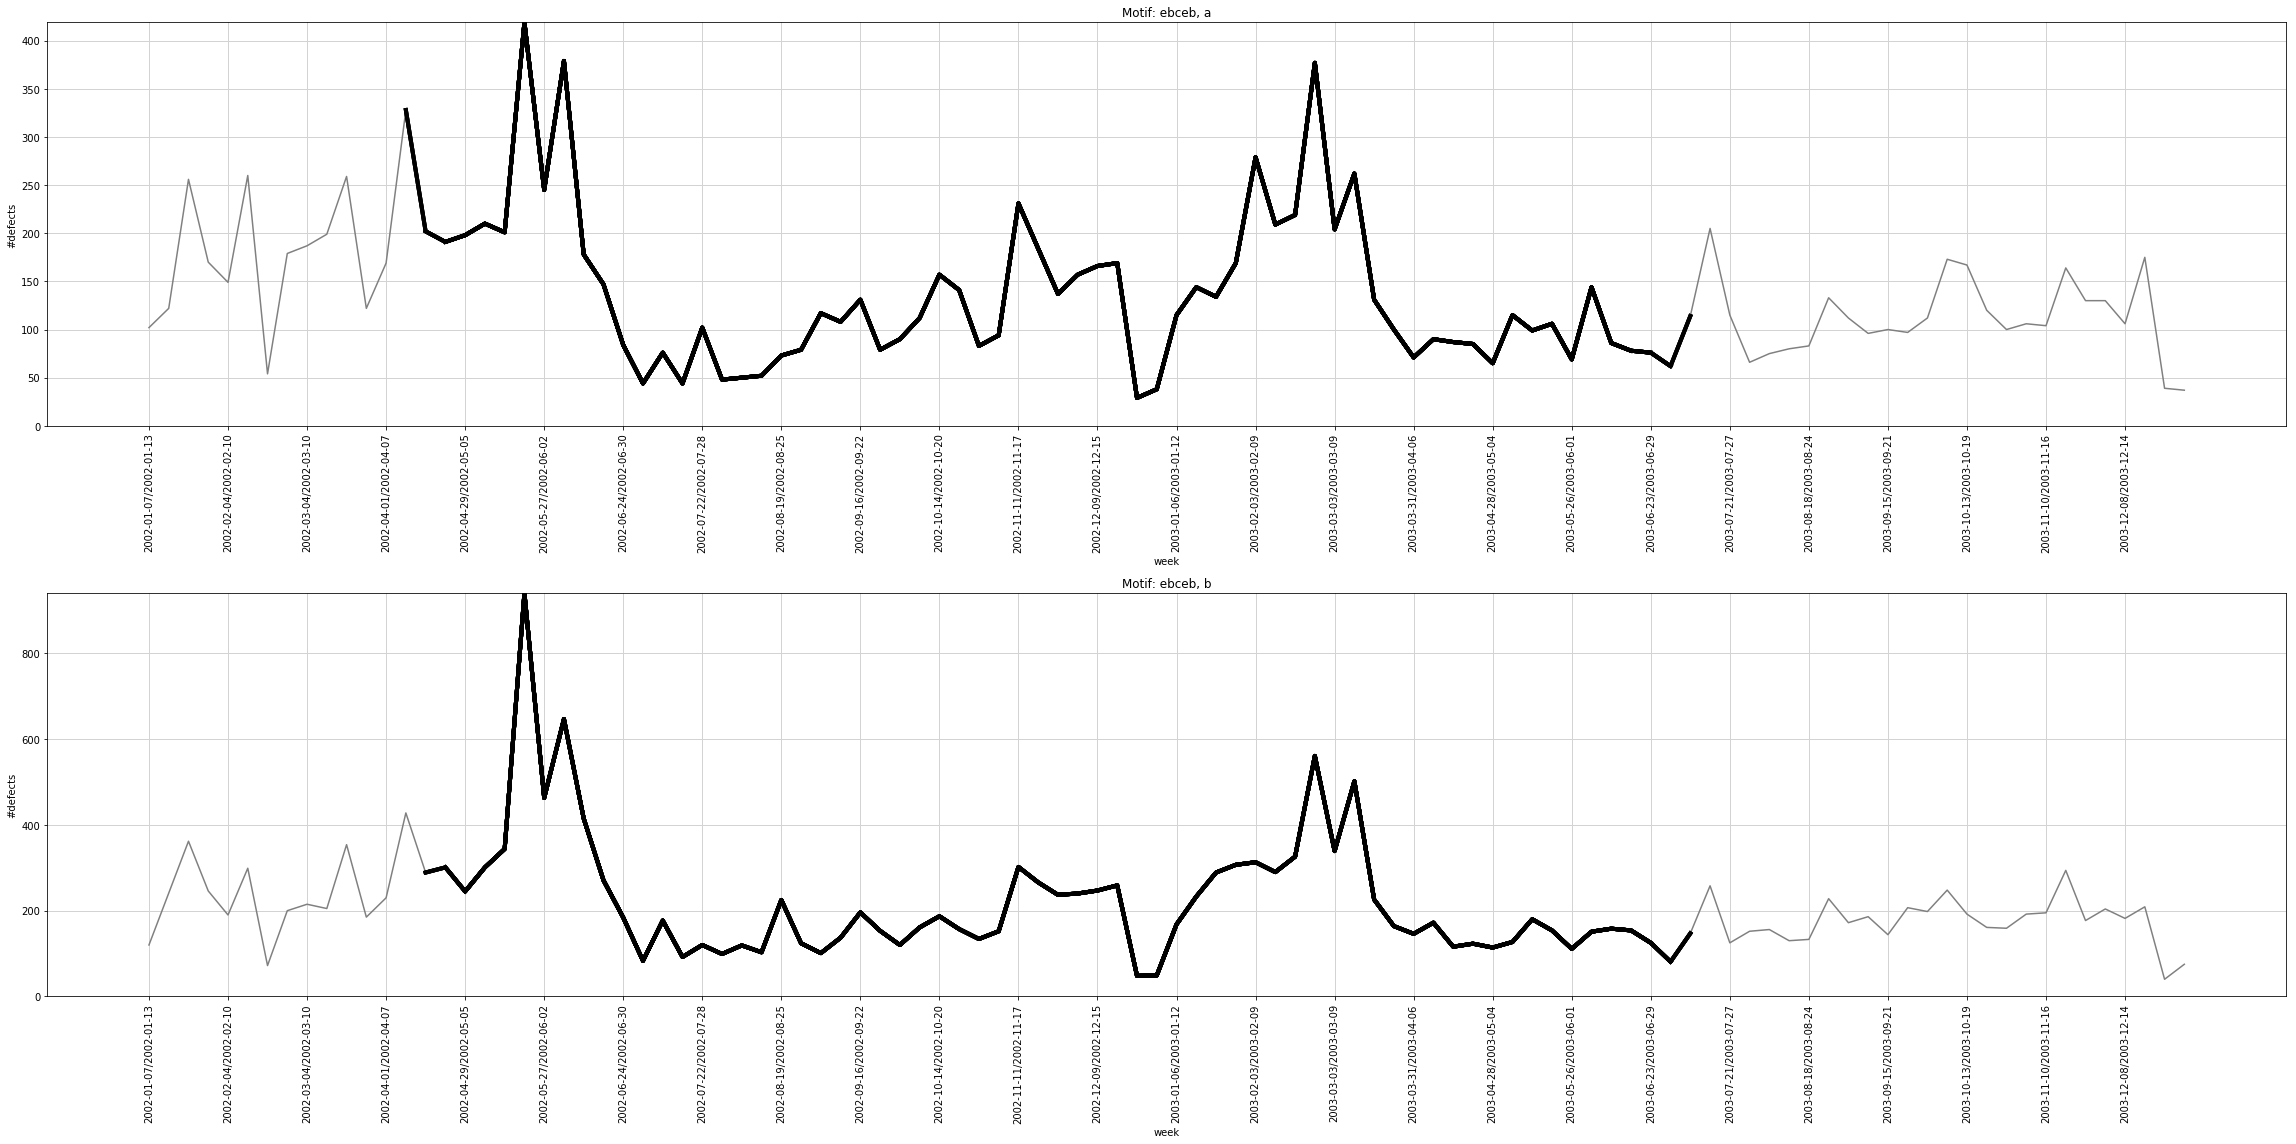

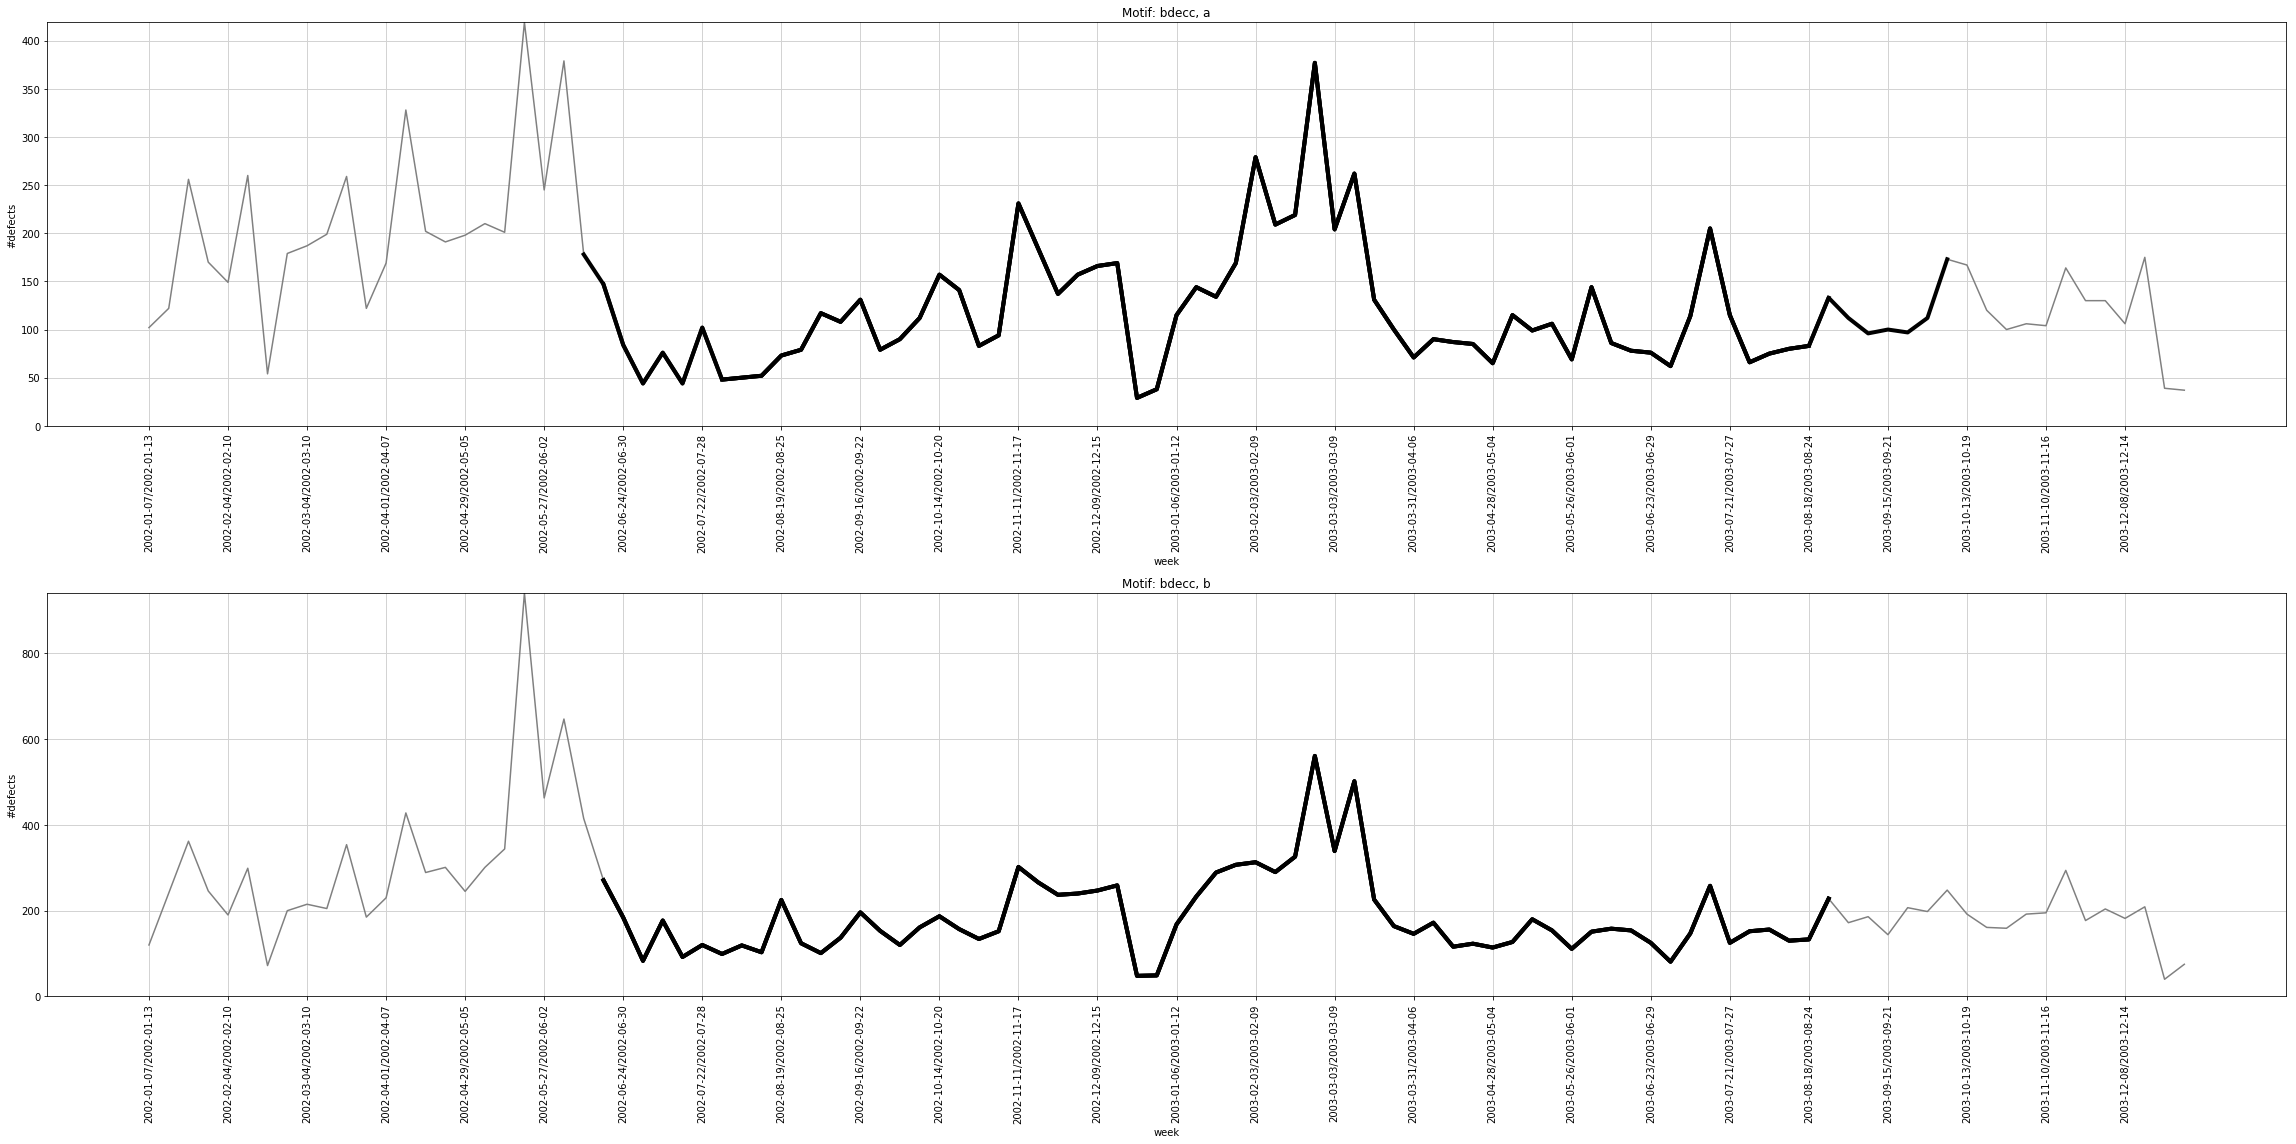

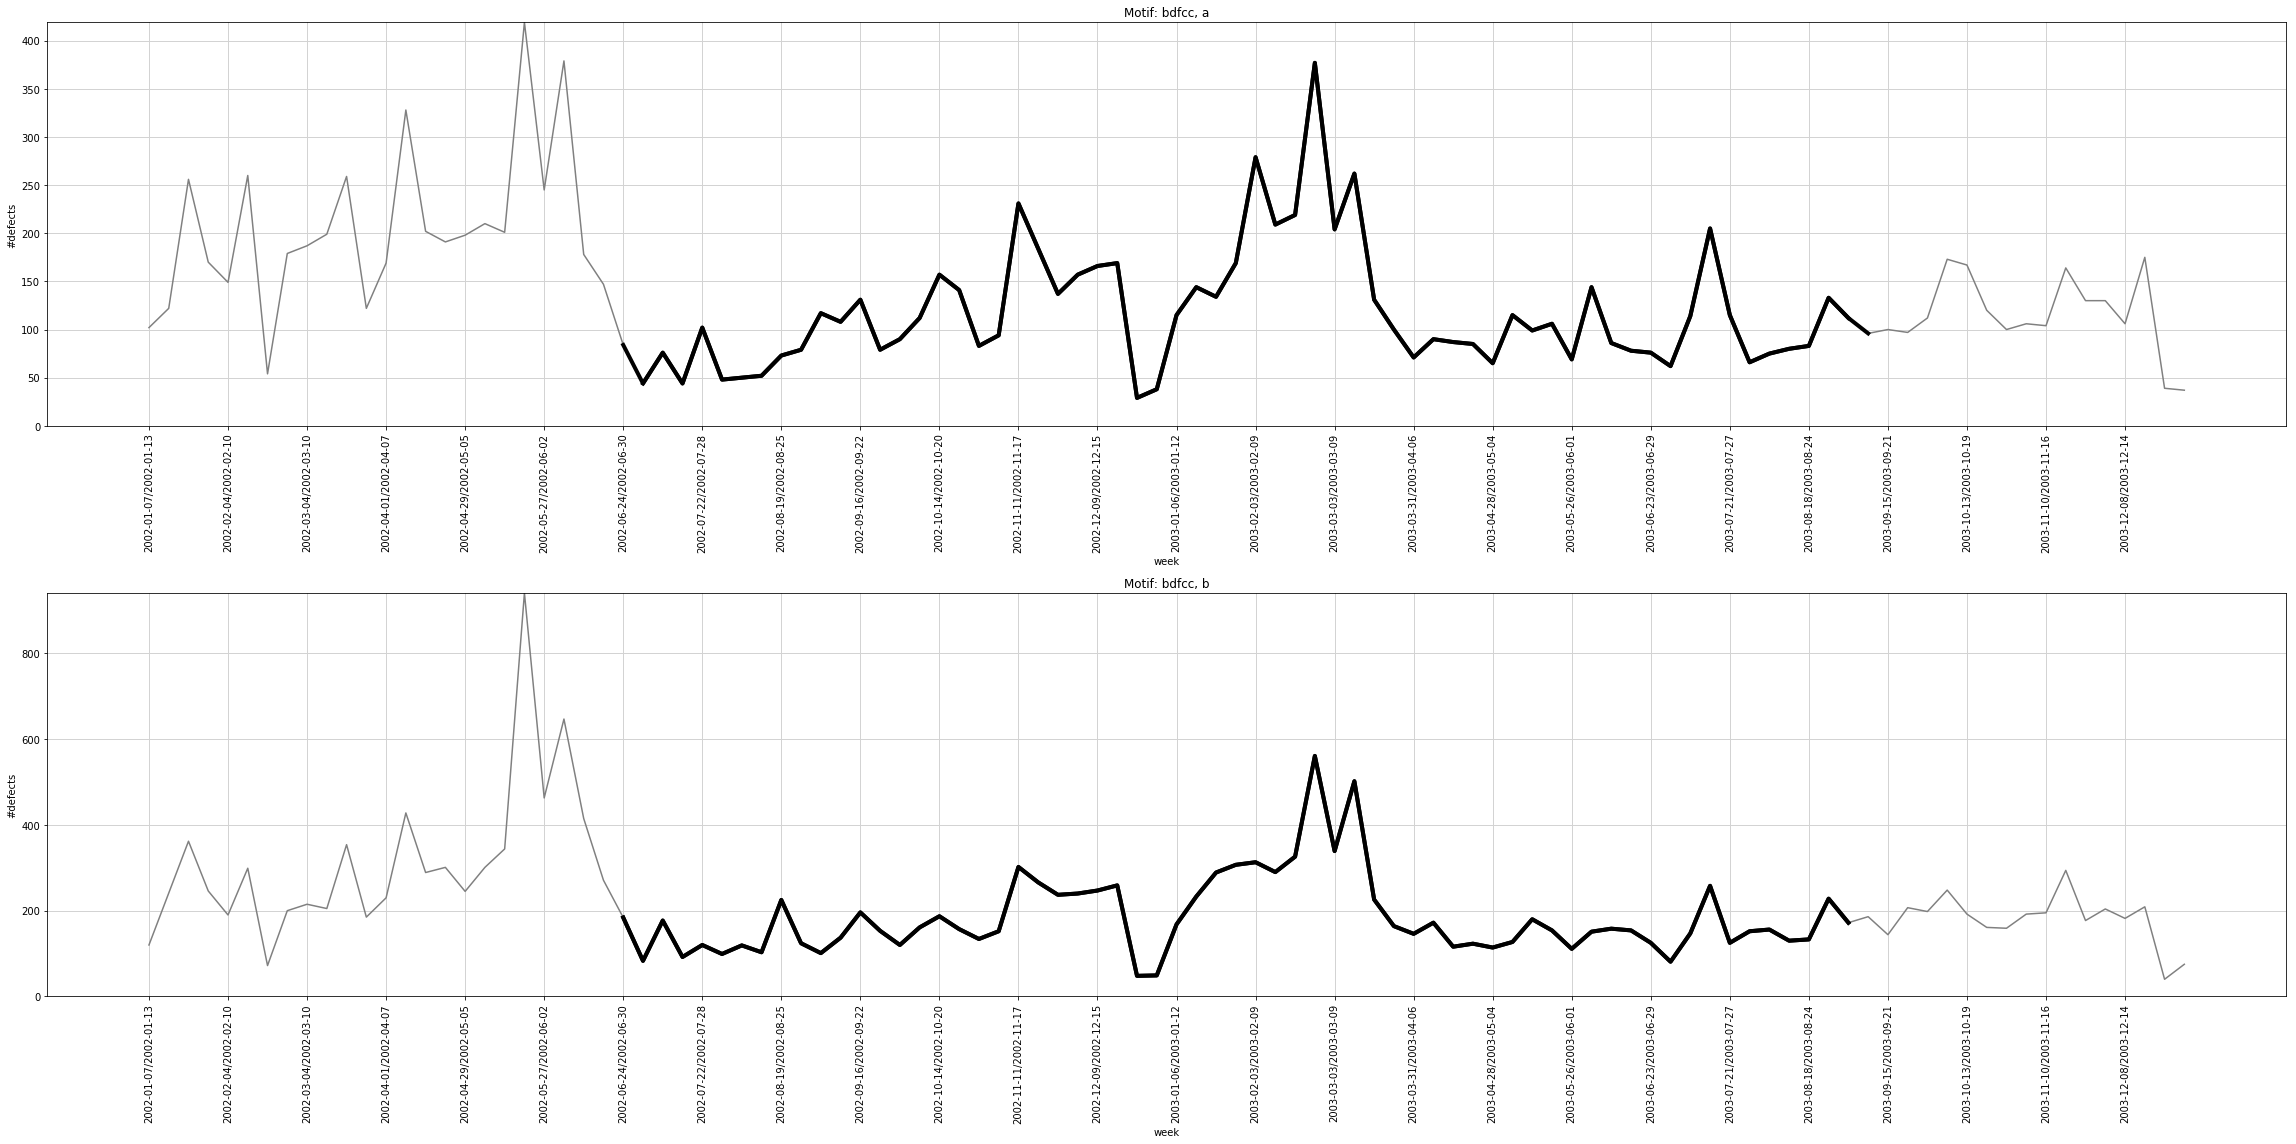

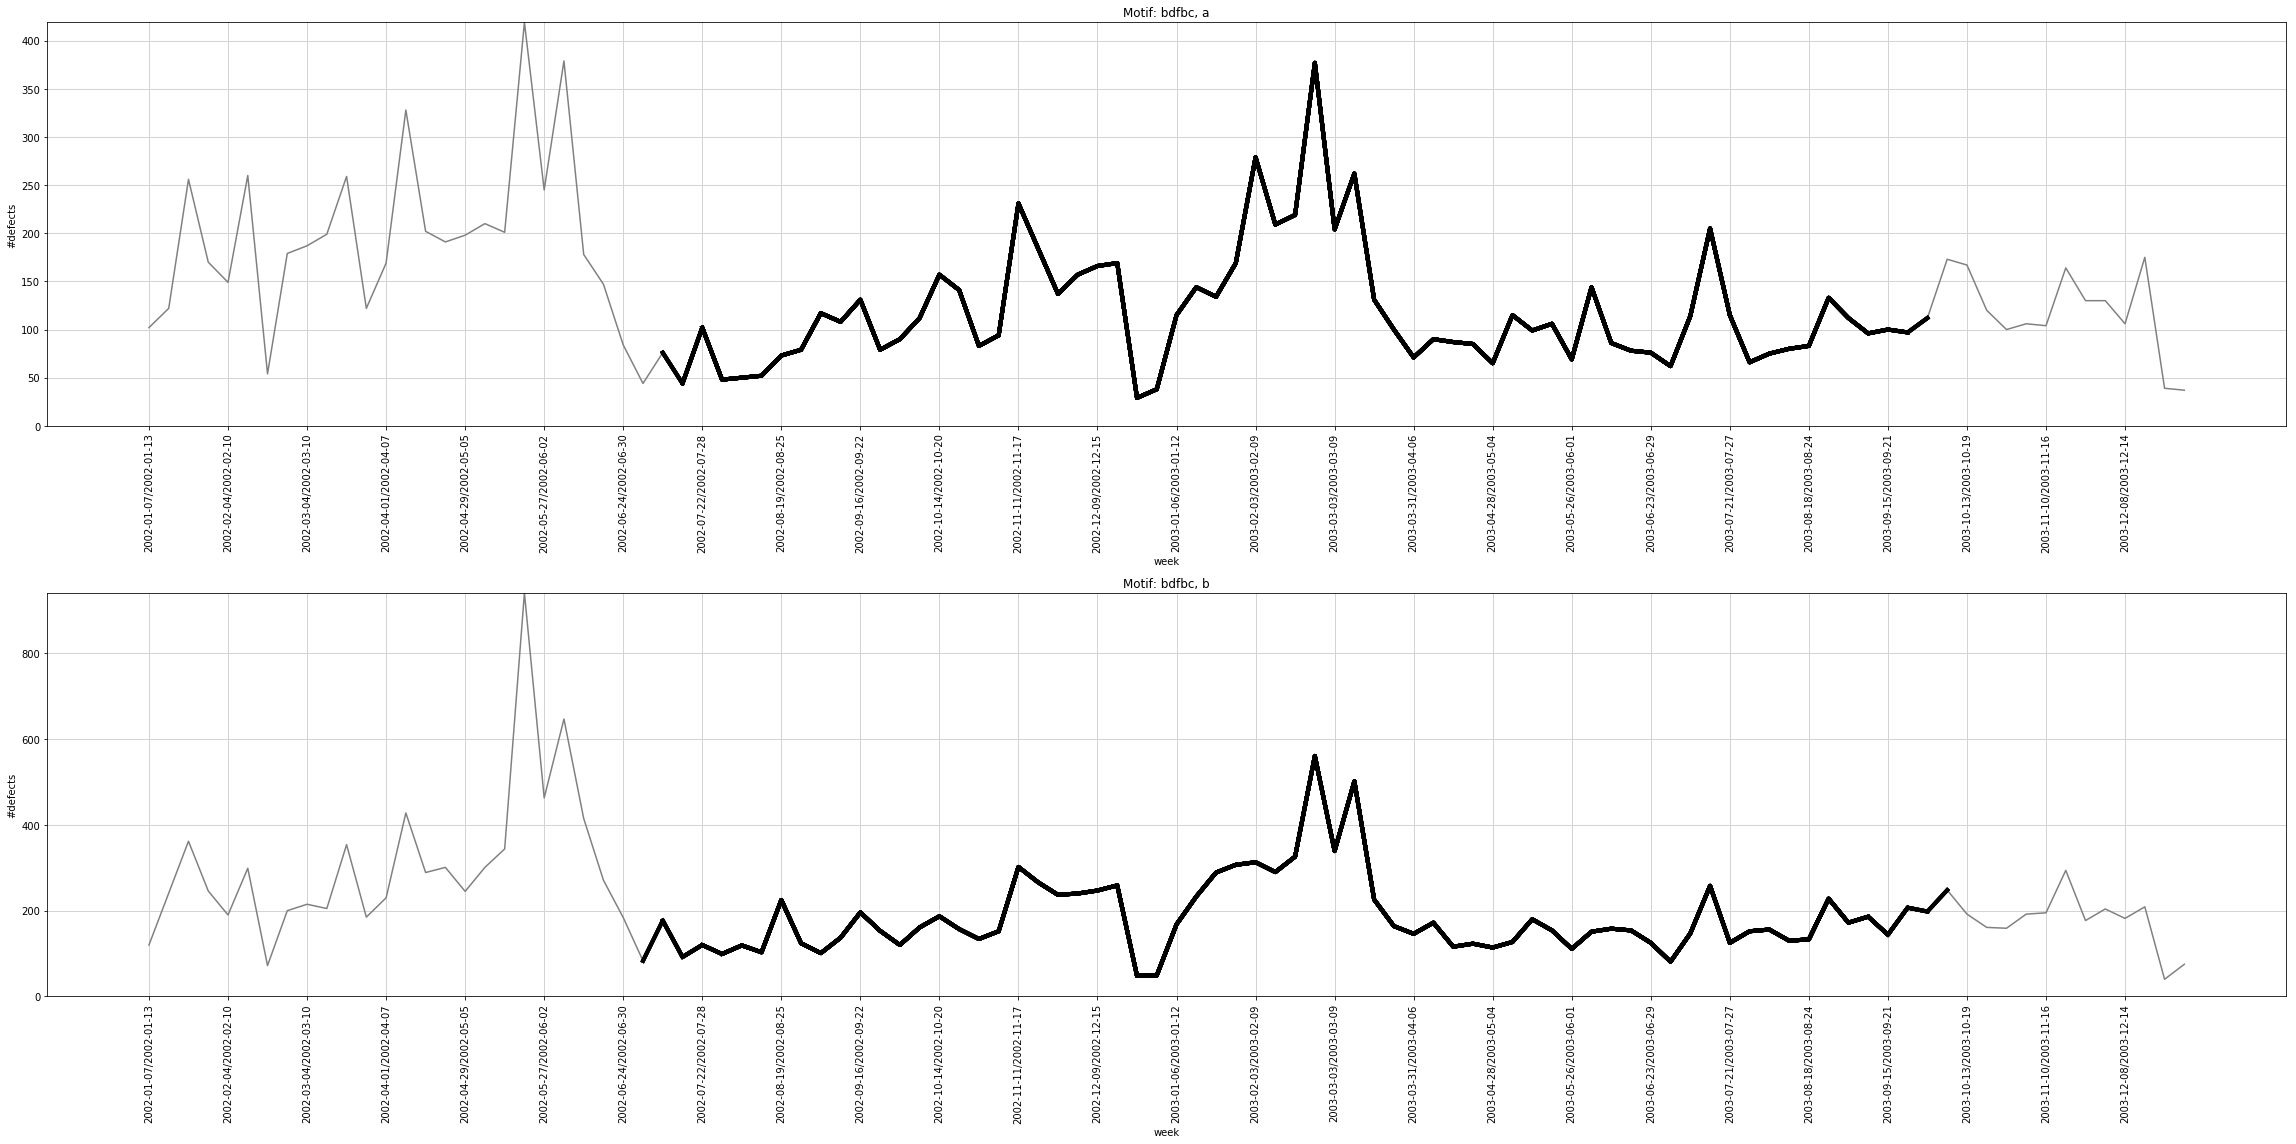

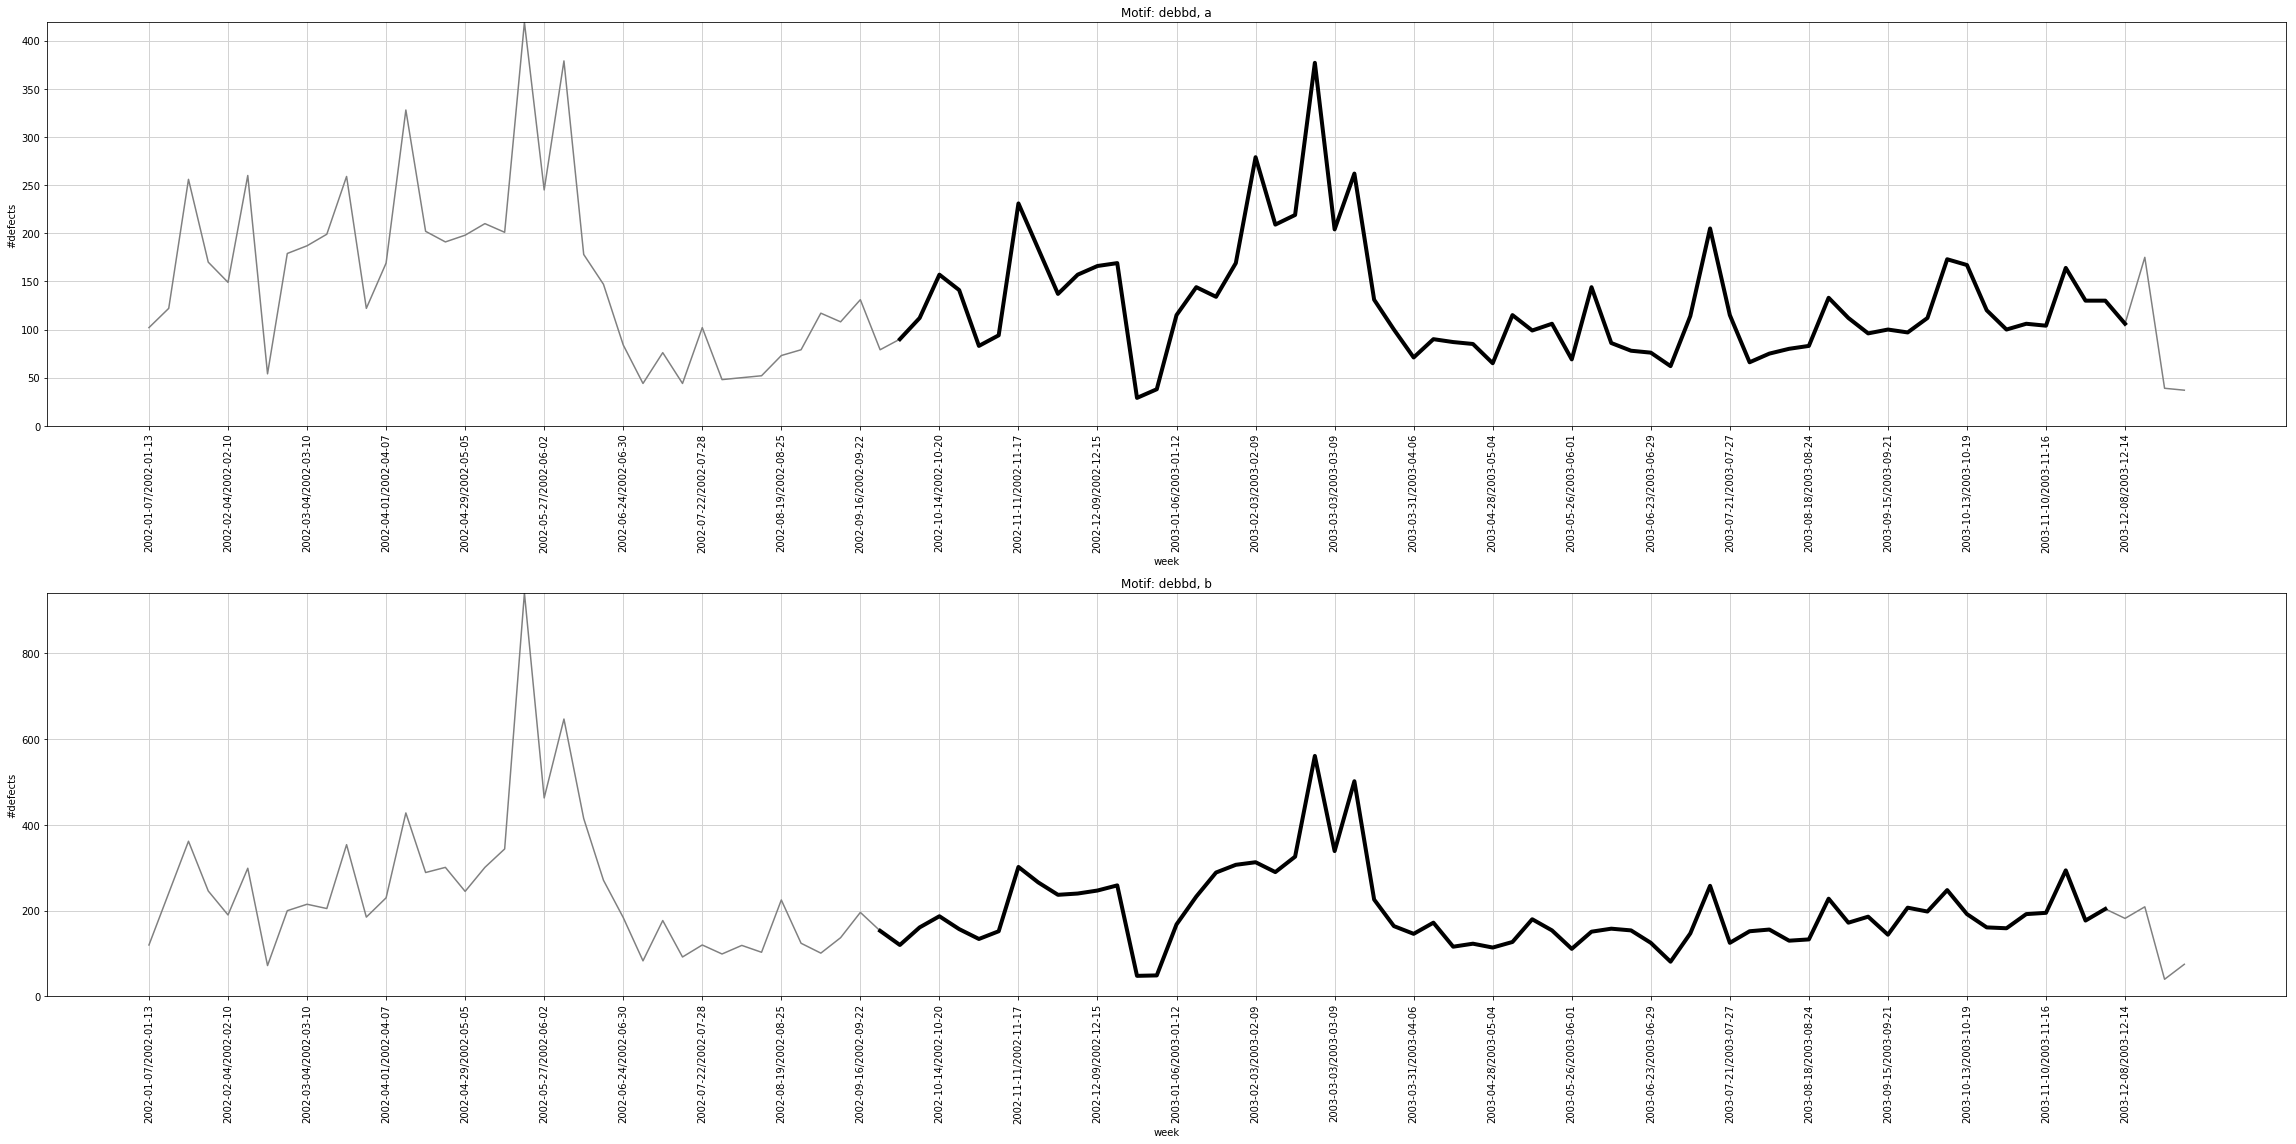

In [12]:
for motif in motifs_between:
    fig_a = plot_comparisons_motif((32,16), project_a_seq, project_b_seq, 'a', 'b',  motif)
    plt.tight_layout()
    plt.show()
    plt.close()

And now, all motifs isoloted:

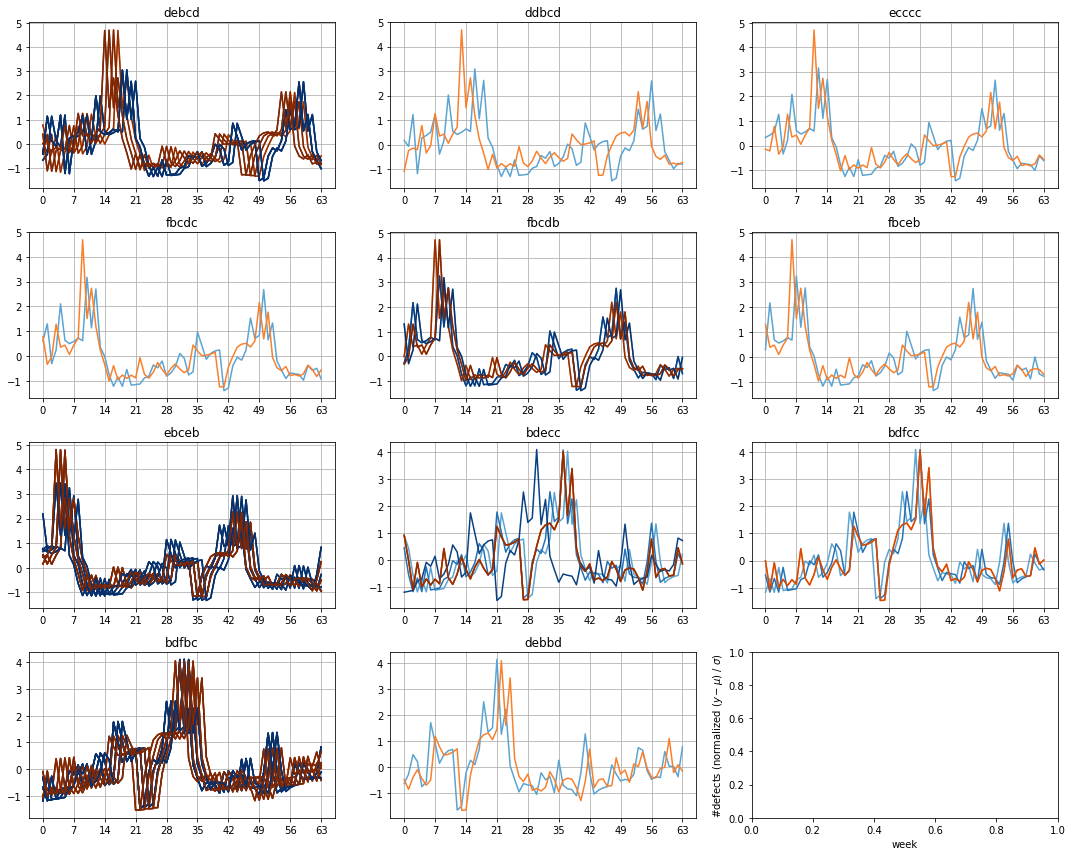

In [13]:
if len(motifs_between) > 0:
    plot_all_motif_alignments(motifs_within=[], motifs_between=motifs_between, width=5, height=3)
    plt.tight_layout()
    plt.show()
    plt.close()